In [368]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.cluster import KMeans
import statsmodels.api as sm
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

# Análisis precipitaciones 1920-2021 en Barcelona.

# 1.ETL.

- **Scrapping**

In [2]:
url='https://datosclima.es/Aemethistorico/Precipisolstad.php'

In [3]:
#Activamos que Selenium esté controlando Chrome y abrimos la web
#Necesitamos descargarnos previamente el driver del navegador que usamos.
DRIVER_PATH = 'Downloads/chromedriver_win32/chromedriver.exe'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)
driver.get(url)

In [4]:
#Extraemos precipitaciones
results1=driver.find_elements_by_tag_name('tr')

In [397]:
prec=[i.text for i in results1]

In [437]:
indices=[]
for i,j in enumerate(prec):
    if j=='FECHA Precipitación: l/m2 Horas Sol:':
        indices.append(i)

In [438]:
prec2=[]
for i in range(len(indices)-1):   
    prec2.extend(prec[indices[i]+1:indices[i+1]])

In [439]:
prec2=[i for i in prec2 if len(i)<30]
prec3=[i.split() for i in prec2]
df_prec_dia=pd.DataFrame(data=prec3,columns=['Fecha','Precipitacion','Horas_Sol'])

- **Tratamiento de nulos y valores no correctos**

In [440]:
df_prec_dia.isnull().sum()

Fecha                0
Precipitacion        0
Horas_Sol        21326
dtype: int64

In [441]:
df_prec_dia.shape

(36512, 3)

Valores **Ip y Acum**: El código Ip significa precipitación inapreciable, es decir, cantidad inferior a 0.1 mm.

In [442]:
df_prec_dia.Precipitacion=df_prec_dia.Precipitacion.replace({'Ip':'0.0'})

In [443]:
df_prec_dia.loc[df_prec_dia.Precipitacion=='Acum',:]

,Fecha,Precipitacion,Horas_Sol
15608,25-09-1962,Acum,None


In [444]:
df_prec_dia.loc[df_prec_dia.Precipitacion=='Acum','Precipitacion']=(float(df_prec_dia.loc[15607,'Precipitacion'])+float(df_prec_dia.loc[15609,'Precipitacion']))/2

In [445]:
df_prec_dia.iloc[15608,:]

Fecha            25-09-1962
Precipitacion          43.5
Horas_Sol              None
Name: 15608, dtype: object

In [446]:
#Convertimos las columnas en datetime y float
df_prec_dia['Precipitacion']=df_prec_dia['Precipitacion'].astype(float)
df_prec_dia['Horas_Sol']=df_prec_dia['Horas_Sol'].astype(float)
df_prec_dia['Fecha']=pd.to_datetime(df_prec_dia['Fecha'])

In [447]:
df_prec_dia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36512 entries, 0 to 36511
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          36512 non-null  datetime64[ns]
 1   Precipitacion  36512 non-null  float64       
 2   Horas_Sol      15186 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 855.9 KB


In [448]:
df_prec_dia.head()

,Fecha,Precipitacion,Horas_Sol
0,1920-01-01,3.5,NaN
1,1920-02-01,0.0,NaN
2,1920-03-01,0.0,NaN
3,1920-04-01,16.3,NaN
4,1920-05-01,7.9,NaN


In [214]:
df_prec_dia.to_csv('precipitacionesBCN.csv',index=False)

- **Carga en MySQL**

In [413]:
#Conexión con base de datos MySQL
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="****", 
  database="lluviaBCN"
)

In [414]:
mycursor = mydb.cursor()

In [457]:
#convertimos formato datetime to MySQL
df_prec_dia['Fecha']=df_prec_dia['Fecha'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [458]:
#Tabla rain
val=[]
for i in range(len(df_prec_dia)):
    datos=(int(i+1),df_prec_dia.Fecha[i],float(df_prec_dia.Precipitacion[i]))
    val.append(datos)

In [460]:
sql = "insert into rain(id,fecha,precipitacion) values (%s,%s,%s)"

In [461]:
mycursor.executemany(sql,val)

In [462]:
mydb.commit()

# 2. Análisis exploratorio.

### 2.1. Introducción.

In [776]:
#Situacion estaciones meteorológicas BCN
import folium
from branca.element import Figure

fig = Figure(width=950, height=400)
# Define a map centered around Barcelona
barcelona_map = folium.Map(location=[41.38879, 2.15899], zoom_start=12)

marker = folium.Marker(location=[41.42, 2.12],tooltip="Observatori Fabra, 08035 Barcelona")
marker.add_to(barcelona_map)

marker = folium.Marker(location=[41.38, 2.18],tooltip="Ronda Litoral, 08005 Barcelona")
marker.add_to(barcelona_map)
# Display the map
m=barcelona_map
fig.add_child(m)


**AEMET** recoge la información meteorológica de **dos estaciones** situadas en la ciudad de **Barcelona**, una en la montaña del Tibidabo, en el **Observatorio Fabra** y otra al lado del mar en la **Ronda Litoral**. Se escoge la **primera estación** ya que dispone de más **datos históricos, desde 1920**.

### 2.2. Precipitaciones por días.

In [415]:
#Conexión con base de datos MySQL
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="****", 
  database="lluviaBCN"
)

In [416]:
mycursor = mydb.cursor()

In [737]:
query1=pd.read_sql('SELECT *\
                    FROM rain r',mydb)

In [418]:
df_prec_dia=query1[['fecha','precipitacion']]
df_prec_dia.columns=['Fecha','Precipitacion']

In [419]:
#Valores estadísticos
df_prec_dia.Precipitacion.describe()

count    36512.000000
mean         1.690737
std          6.560364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        196.000000
Name: Precipitacion, dtype: float64

In [420]:
#Días sin llover de media
np.round(1-df_prec_dia.loc[df_prec_dia.Precipitacion==0,'Precipitacion'].count()/len(df_prec_dia),1)

0.2

In [421]:
#10 días que ha llovido más
df_prec_dia.sort_values('Precipitacion')[-10:][['Fecha','Precipitacion']]

,Fecha,Precipitacion
34604,2014-09-28,100.4
2434,1926-08-31,113.6
27300,1994-09-29,114.6
35512,2017-03-24,115.1
8748,1943-12-14,116.8
30162,2002-07-31,119.5
3220,1928-10-25,120.5
24748,1987-04-10,144.1
8820,1944-02-24,179.7
18966,1971-05-12,196.0


- **Análisis:**

El nivel de agregación por días es demasiado bajo, muy al detalle, existe un gran número de observaciones y la mayoría son cero. Agrupar los datos en meses y años facilitará el análisis.

En este nivel se observa que **más del 75% de los días no llueve** nada, se puede afirmar que, de media, solo llueve 2 días de cada diez y cuando lo hace no es siempre en grandes cantidades.

En el otro extremo tenemos días que, en comparación, llueve mucho, valores superiores a 100mm cuando de media en Barcelona caen 50mm/mes. El **valor máximo** son **196mm** y data de mayo de **1971**.

En la tabla superior **no se observa un aumento en la frecuencia** de este tipo de días, **jornadas con precipitaciones máximas, de las últimas dos décadas respecto a años anteriores**.

En el **gráfico inferior** se observan las **distribuciones acumuladas de días sin lluvia y precipitaciones extremas**, las dos **crecen de forma constante** por lo que **no hay un aumento** de estos casos en los últimos 20 años respecto a años anteriores.

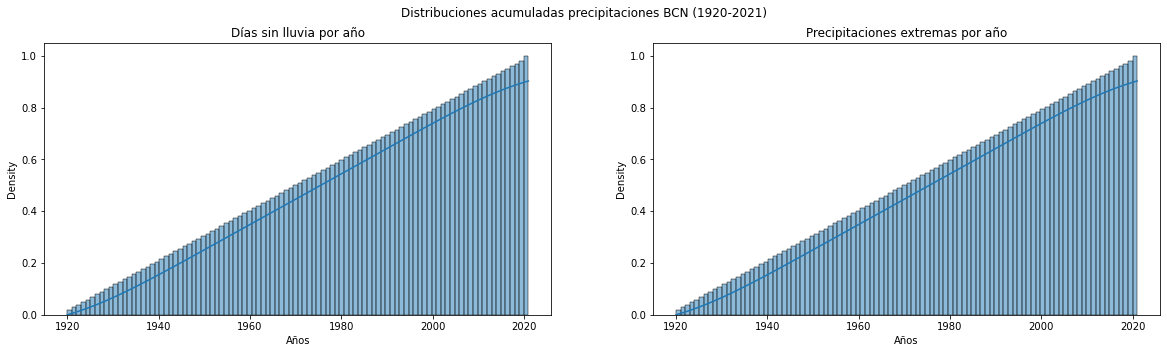

In [770]:
#Plots distribución acumulada días sin lluvia y lluvias extremas por año
Q1=df_prec_dia.Precipitacion.quantile(0.25)
Q3=df_prec_dia.Precipitacion.quantile(0.75)
IQR=Q3-Q1

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
# Distribución acumulada días sin lluvia por año
df_prec_dia_min=df_prec_dia.loc[df_prec_dia.Precipitacion==df_prec_dia.Precipitacion.min(),:]
df_prec_dia_min2=df_prec_dia_min.resample('Y', on='Fecha').count()[['Precipitacion']].reset_index()
sns.histplot(df_prec_dia_min2.Fecha.dt.year,kde=True, bins=100,cumulative=True,stat='density')
plt.xlabel('Años')
plt.title('Días sin lluvia por año')

plt.subplot(1,2,2)
# Distribución acumulada días precipitación extrema por año
df_prec_dia_max=df_prec_dia.loc[df_prec_dia.Precipitacion>(Q3 + 1.5 * IQR),:]
df_prec_dia_max2=df_prec_dia_max.resample('Y', on='Fecha').count()[['Precipitacion']].reset_index()
sns.histplot(df_prec_dia_max2.Fecha.dt.year,kde=True, bins=100,cumulative=True,stat='density')
plt.title('Precipitaciones extremas por año')
plt.xlabel('Años')
plt.suptitle('Distribuciones acumuladas precipitaciones BCN (1920-2021)')
plt.show()

### 2.3. Precipitaciones por meses.

In [422]:
df_prec_mes = df_prec_dia.resample('M', on='Fecha').sum()

In [423]:
#Valores estadísticos
df_prec_mes.Precipitacion.describe()

count    1224.000000
mean       50.434804
std        42.708762
min         0.000000
25%        18.775000
50%        39.850000
75%        70.300000
max       293.900000
Name: Precipitacion, dtype: float64

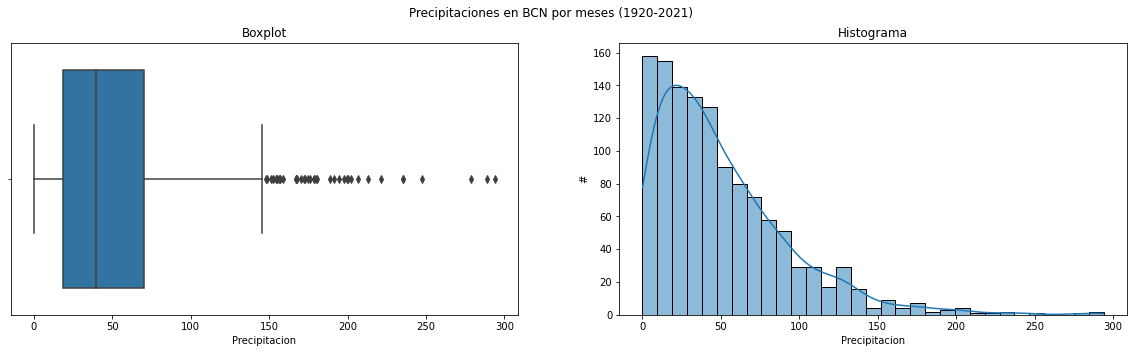

In [771]:
#Boxplot e histograma precipitaciones por meses
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(x='Precipitacion',data=df_prec_mes)
plt.title('Boxplot')
plt.subplot(1,2,2)
sns.histplot(df_prec_mes.Precipitacion,kde=True)
plt.ylabel('#')
plt.title('Histograma')
plt.suptitle('Precipitaciones en BCN por meses (1920-2021)')
plt.show()

- **Análisis:**

**Agrupado por meses** se puede observar que las **precipitaciones** tienen una **media de 50.43mm/mes** y una **mediana de 39.85mm/mes**. Esta diferencia se debe a la existencia de outliers que afectan más la media que a la mediana.
En el **histograma** se observa que el valor más repetido es cero seguido de valores con baja precipitación, lo que **confirma** que en Barcelona la **mayoría de meses llueve o nada o muy poco.** 
La forma asimétrica hacia la derecha del histograma muestra que **hay meses**, los menos, que **llueve mucho más de lo habitual, a partir de 150mm/mes.**
La máxima precipitación mensual son casi 300mm/mes.

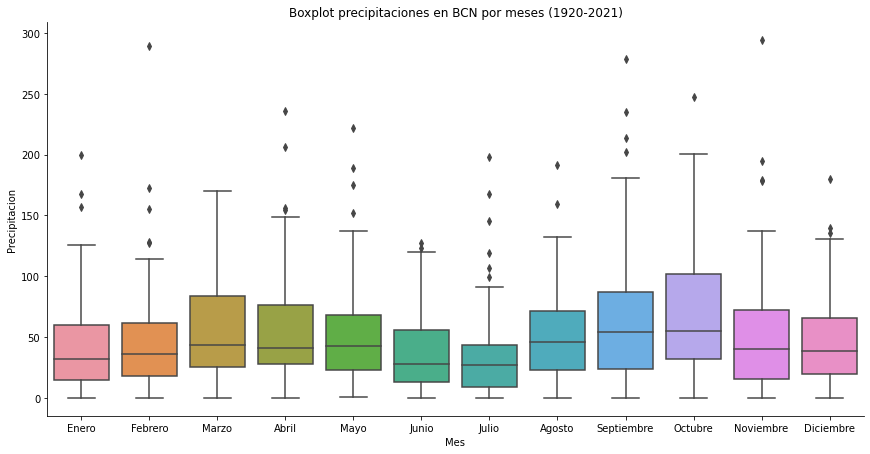

In [772]:
#Precipitaciones media por meses
df_prec_mes=df_prec_mes.reset_index()
df_prec_mes['Mes']=df_prec_mes.Fecha.dt.month
meses={1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',\
       8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}
df_prec_mes.Mes=df_prec_mes.Mes.map(meses)
ax = sns.catplot(x='Mes', y='Precipitacion',kind='box',data=df_prec_mes, height=6,aspect=2)
plt.title('Boxplot precipitaciones en BCN por meses (1920-2021)')
plt.show()

- **Análisis:**

En todo el histórico, se observa que hay **dos periodos al año que llueve más**: el primero sería **entre Marzo y Abril** y el segundo **entre Septiembre y Octubre**. En cambio **en Junio y Julio** las **precipitaciones** son las **más bajas** de los 12 meses.

Se puede observar la **estacionalidad de las precipitaciones** que corresponde a un aumento de las precipitaciones en los meses típicos de primavera y otoño mientras que en verano se produce el efecto contrario.

La **variabilidad en los 12 meses es muy similar** en todos ellos, el mes de Octubre es la que tiene un valor ligeramente más elevado. Respecto a los outliers, no hay un número muy elevado de estos, lo que indica que las precipitaciones tienen un comportamiento bastante estable.

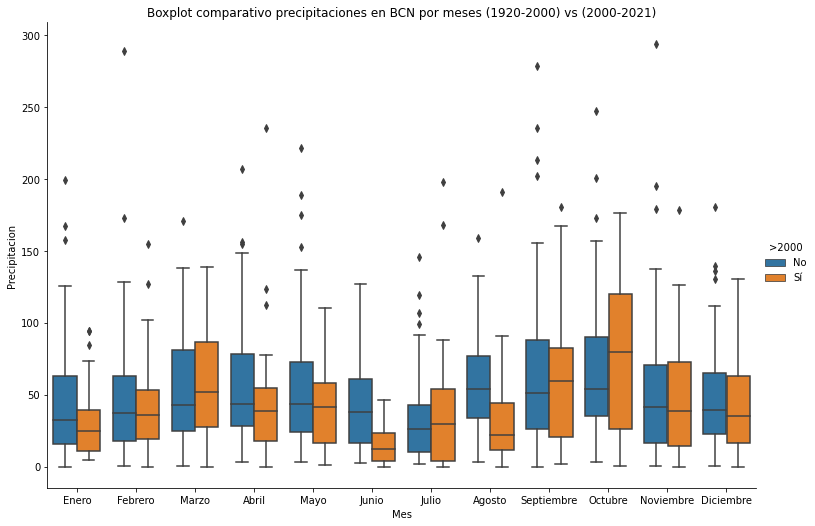

In [773]:
#Comparación precipitaciones por meses histórico vs 2000-2021
df_prec_mes2=df_prec_mes.copy()
df_prec_mes2['>2000']=df_prec_mes2.Fecha.apply(lambda x:'Sí' if x.year>1999 else 'No')
ax = sns.catplot(x='Mes', y='Precipitacion', kind='box',data=df_prec_mes2, hue='>2000',height=7,aspect=1.5)
plt.title('Boxplot comparativo precipitaciones en BCN por meses (1920-2000) vs (2000-2021)')
plt.show()

- **Análisis:**

Comparando los dos periodos se observa un **comportamiento similar en la mayoría de los meses**, aunque se aprecia un **descenso notable** de las precipitaciones en los meses de **Junio y Agosto** del siglo XXI, respecto al periodo anterior.  En cambio, en los meses del año que más llueve, **Septiembre y Octubre**, **se observa un aumento** en las precipitaciones respecto a las producidas en el siglo XX.

Es decir que en los **últimos 20 años** los **periodos de pocas lluvias y mayores precipitaciones son más extremos**. Los meses de Junio, Julio y Agosto son mucho más secos que antes mientras que Octubre y Noviembre, los meses habituales de lluvia, llueve más.

Desde un **punto de vista anual**, estos **aumentos de lluvia  no compensan**, del todo, **el descenso de precipitaciones** producido en los meses de Junio, Julio y Agosto.

### 2.4. Precipitaciones por años.

In [427]:
df_prec_year=df_prec_dia.resample('Y', on='Fecha').sum()

In [428]:
#Valores estadístico
df_prec_year.Precipitacion.describe()

count     102.000000
mean      605.217647
std       171.418856
min        13.100000
25%       488.350000
50%       577.850000
75%       691.825000
max      1122.900000
Name: Precipitacion, dtype: float64

In [429]:
# Precipitación anual máxima
df_prec_year.loc[df_prec_year.Precipitacion==df_prec_year.Precipitacion.max(),:]

,Precipitacion
Fecha,
1971-12-31,1122.9


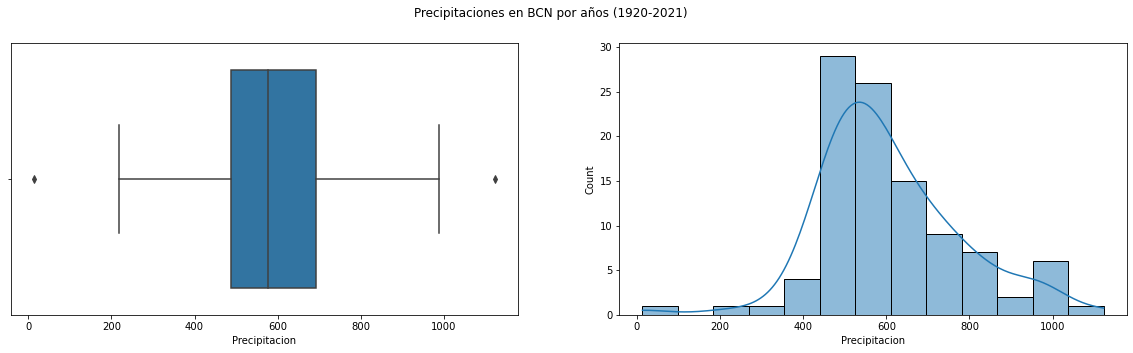

In [774]:
#Boxplot e histograma precipitaciones por años
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(x='Precipitacion',data=df_prec_year)
plt.subplot(1,2,2)
sns.histplot(df_prec_year.Precipitacion,kde=True)
plt.suptitle('Precipitaciones en BCN por años (1920-2021)')
plt.show()

- **Análisis:**

Al **aumentar el nivel de agregación** la distribución se asemeja más a una **distribución normal simétrica**. Ahora no tienen casi outliers, el caso cercano a cero, que se observa en el boxplot, se debe al año 2021 que aún no está finalizado y el de la derecha corresponde a 1971, el mismo año del día con más lluvia de todo el histórico.

Ahora la media y la mediana están más próximas que antes, 605.21mm/año y 577.85 mm/año respectivamente.
La falta de outliers demuestra que las precipitaciones por año no sufren valores extremos y son bastante estables.

In [431]:
start_year=2000

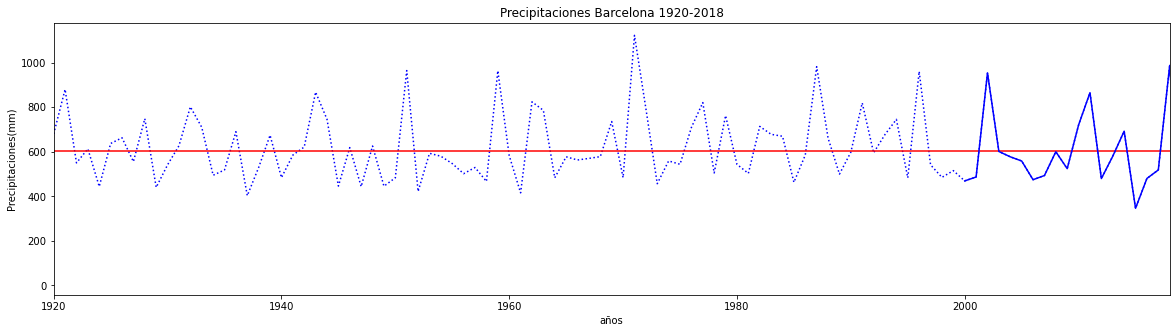

In [775]:
#Cronograma precipitaciones por año
df_prec_year2=df_prec_year.reset_index()
plt.figure(figsize=(20,5))
plt.plot(df_prec_year2.Fecha.dt.year,df_prec_year2.Precipitacion, color='b',linestyle=':')
plt.axhline(y=df_prec_year2.Precipitacion.mean(), color='r', linestyle='-')
plt.plot(df_prec_year2.Fecha.dt.year[df_prec_year2.Fecha.dt.year>=start_year],df_prec_year2.loc[df_prec_year2.Fecha.dt.year>=start_year,'Precipitacion'],color='b')
plt.xlim(1920,2018)
plt.ylabel('Precipitaciones(mm)')
plt.xlabel('años')
plt.title('Precipitaciones Barcelona 1920-2018')
plt.show()

- **Análisis:**

En el histórico anual **se entremezclan** los picos y valles, es decir, **años más intensos de lluvias con años secos**, se aprecia cierta **periocidad**. La media anual de las precipitaciones (línea roja) nos permite observar que se combinan, **habitualmente varios años secos con un año con precipitaciones superiores a la media**.

Respecto a los **últimos 20 años** (línea azul continua) se observa la misma tónica que en años anteriores aunque **se visualizan más años de sequía y picos menos pronunciados**.

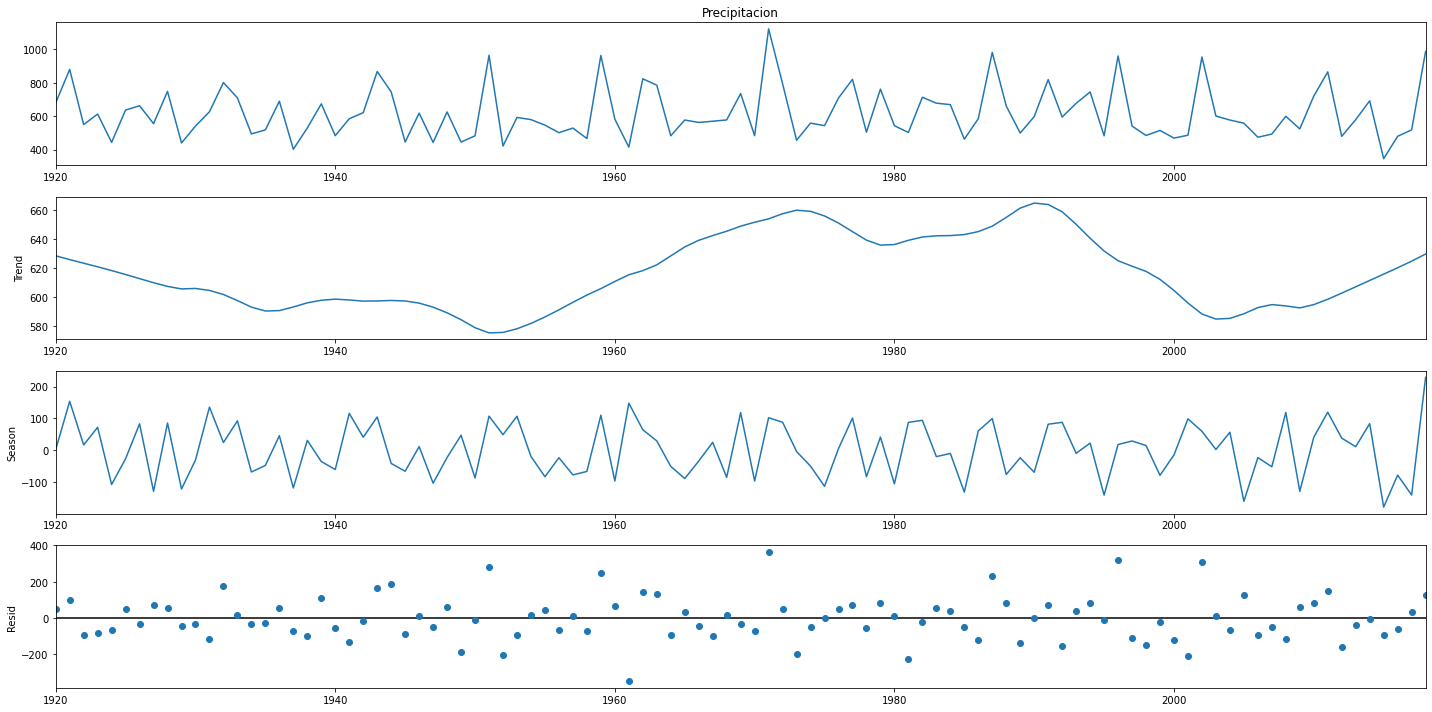

In [434]:
# Separación en tendencia y estacionalidad
from statsmodels.tsa.seasonal import STL
df_prec_year2['year']=df_prec_year2['Fecha'].dt.year
df_prec_year2=df_prec_year2.set_index('year')
stl = STL(df_prec_year2.Precipitacion[:-3],period=10)
res = stl.fit()
res.plot()
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

- **Análisis:**

En la segunda gráfica, **en tendencia**, se observa que **desde 1920 hasta 1950** las **precipitaciones descendieron ligeramente** desde 630mm/año hasta 580mm/año. **Desde 1950** el **incremento anual es constante** hasta estabilizarse en torno a 650mm/año.

A partir de 1990 vuelve a su mínimo histórico 580mm/año en un plazo de 10 años. **Desde el año 2000** las **precipitaciones anuales** se han **mantenido en valores bajos** exceptuando 2018 que llovió bastante e impulsó la tendencia al alza.

Visualmente la tendencia muestra que la **serie temporal es estacionaria**, lo comprobamos en la celda inferior, el valor de p_value=0 indica que lo es.

In [435]:
#Test Dickey-Fuller
from statsmodels.tsa.stattools import adfuller
s#eries = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
X = df_prec_year.Precipitacion.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.885676
p-value: 0.000000
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


# 3. Aprendizaje no supervisado.

In [436]:
df_prec_mes.head()

,Fecha,Precipitacion,Mes
0,1920-01-31,15.5,Enero
1,1920-02-29,37.5,Febrero
2,1920-03-31,38.6,Marzo
3,1920-04-30,30.1,Abril
4,1920-05-31,18.9,Mayo


In [437]:
# Analizamos 10 clusters
ks=range(2,11)
inertias=[]
sil_K=[]
for i in ks:
    model=KMeans(n_clusters=i, random_state=0)
    model.fit(df_prec_mes[['Precipitacion']])   
    inertias.append(model.inertia_)    
    labels = model.predict(df_prec_mes[['Precipitacion']])
    silhouette_avg = silhouette_score(df_prec_mes[['Precipitacion']],labels)
    sil_K.append(silhouette_avg)

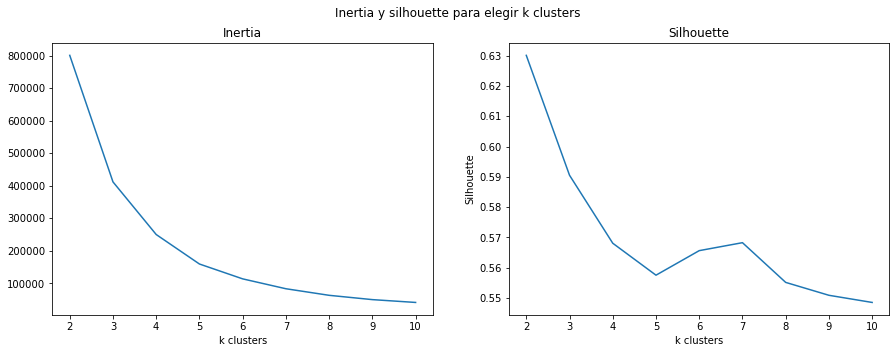

In [438]:
#Plots de inertia y silhouette
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(ks,inertias)
plt.xlabel('k clusters')
plt.title('Inertia')

plt.subplot(1,2,2)
plt.plot(ks,sil_K)
plt.title('Silhouette')
plt.xlabel('k clusters')
plt.ylabel('Silhouette')
plt.suptitle('Inertia y silhouette para elegir k clusters')
plt.show()

- **Análisis:**

Se realiza un **análisis no supervisado**, en concreto un **KMeans** sobre las precipitaciones a nivel mensual para localizar posibles grupos con características similares. Se han analizado diferentes divisiones, hasta k=10, se observa en el gráfico superior que para inertia el valor más idóneo sería k=3 mientras que para silhouette el cluster es k=2.

**Se escoge** este último valor **k=2** que tiene uns silhouette de 0.63

In [440]:
model=KMeans(n_clusters=2, random_state=0)
labels=model.fit_predict(df_prec_mes[['Precipitacion']])

In [441]:
df_prec_mes['label']=labels

In [442]:
print('Cluster 0:')
print(df_prec_mes.loc[df_prec_mes['label']==0,'Precipitacion'].describe())
print('\nCluster 1:')
print(df_prec_mes.loc[df_prec_mes['label']==1,'Precipitacion'].describe())

Cluster 0:
count    910.000000
mean      30.356923
std       19.309261
min        0.000000
25%       14.300000
50%       28.550000
75%       44.950000
max       69.400000
Name: Precipitacion, dtype: float64

Cluster 1:
count    314.000000
mean     108.622293
std       38.415252
min       69.500000
25%       81.150000
50%       96.050000
75%      125.325000
max      293.900000
Name: Precipitacion, dtype: float64


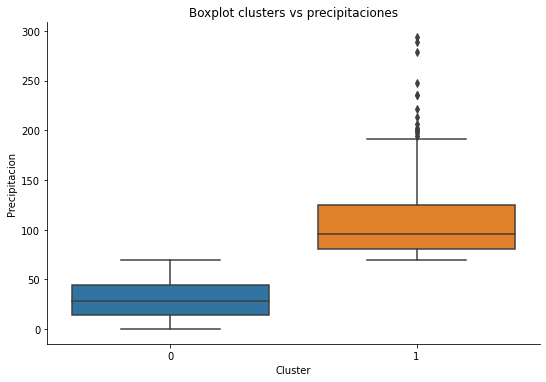

In [443]:
#Boxplots por clusters
ax = sns.catplot(x='label', y='Precipitacion',kind='box',data=df_prec_mes, height=5,aspect=1.5)
plt.title('Boxplot clusters vs precipitaciones')
plt.xlabel('Cluster')
plt.show()

- **Análisis:**

Los **grupos se crean a partir de la cantidad de lluvia que cae por mes**. El **cluster 0** agrupa meses en los que llueve de **media 30.35mm/mes** mientras que el **cluster 1** corresponde a precipitaciones más elevadas de **108.62mm/mes**.

In [444]:
#Distribución de meses por cluster
niveles={0:'Bajo',1:'Alto'}
df_prec_mes['label']=df_prec_mes['label'].map(niveles)
df=pd.crosstab(df_prec_mes.Mes,df_prec_mes.label, normalize='index')
df

label,Alto,Bajo
Mes,,
Abril,0.274510,0.725490
Agosto,0.284314,0.715686
Diciembre,0.186275,0.813725
Enero,0.205882,0.794118
Febrero,0.196078,0.803922
Julio,0.137255,0.862745
Junio,0.166667,0.833333
Marzo,0.323529,0.676471
Mayo,0.245098,0.754902


- **Análisis:**

Al cruzar los clusters con los meses se observa la proporción de éstos según si ha llovido poco (nivel bajo) o mucho (nivel alto).
Por ejemplo, se observa que casi el **40% de los meses de Octubre y Septiembre llueve a nivel alto**. En sentido contrario, solo **el 13.72% de los meses de Julio tienen unas altas precipitaciones**.
Estos **datos concuerdan con el resultado obtenido en el análisis exploratorio** por meses realizado anteriormente.

Ahora se analiza la distribución de los meses por clusters pero sólo desde el año 2000:

In [32]:
#Distribución de meses por cluster 2000-2021
df_prec_mes2['label']=labels
df_prec_mes2['label']=df_prec_mes2['label'].map(niveles)
df2=pd.crosstab(df_prec_mes2.loc[df_prec_mes2['>2000']=='Sí','Mes'],\
            df_prec_mes2.loc[df_prec_mes2['>2000']=='Sí','label'], normalize='index')
tabla=pd.concat([df,df2],axis=1)
tabla.columns=['Alto','Bajo','Alto >2000','Bajo >2000']
tabla

,Alto,Bajo,Alto >2000,Bajo >2000
Mes,,,,
Abril,0.274510,0.725490,0.181818,0.818182
Agosto,0.284314,0.715686,0.181818,0.818182
Diciembre,0.186275,0.813725,0.181818,0.818182
Enero,0.205882,0.794118,0.181818,0.818182
Febrero,0.196078,0.803922,0.181818,0.818182
Julio,0.137255,0.862745,0.227273,0.772727
Junio,0.166667,0.833333,0.000000,1.000000
Marzo,0.323529,0.676471,0.363636,0.636364
Mayo,0.245098,0.754902,0.136364,0.863636


- **Análisis:**

Se observa en la tabla que **a partir del año 2000** los **meses en lo que llovía poco se acentúa la tendencia** y llueve menos, por ejemplo, Abril, Agosto, etc. Mientras que los **meses donde más llovía (Octubre y Septiembre) llueve aún más**,sobretodo en Octubre.
Este **resultado también concuerda con lo que se indicó en el análisis exploratorio**. En los últimos veinte años los periodos de meses secos y mayores precipitaciones se han acentuado .

# 4. Análisis supervisado.

La **lluvia** es un fenómeno atmosférico que **depende de tres factores** principalmente: **temperatura, presión atmosférica y humedad relativa.**

Los datos extraídos anteriormente solo contenían la cantidad de lluvia caída por día. El resto de variables se obtienen otra vez a través de AEMET pero solicitando previamente una API Key para acceder a los datos.

Por tanto, se descargan los **datos históricos** desde el **año 2000 hasta la actualidad** de la estación del **Observatorio Fabra** que contienen, entre otras, las magnitudes de **precipitación, presión atmosférica, temperatura y humedad relativa** en formato **mensual**.

- **Extracción de nuevos datos**

In [ ]:
df=pd.DataFrame()

In [ ]:
def convert_df(r):
    aemet=r.json()
    df=pd.DataFrame(aemet)
    df=df.iloc[:-1,:]
    df.drop('indicativo','columns',inplace=True)
    df['p_max']=df['p_max'].apply(lambda x: x.split('(')[0])
    df['q_max']=df['q_max'].apply(lambda x: x.split('(')[0])
    df['ta_max']=df['ta_max'].apply(lambda x: x.split('(')[0])
    df['w_racha']=df['w_racha'].apply(lambda x: x.split('(')[0] if x is not np.nan else np.nan)
    df['w_racha_dir']=df['w_racha'].apply(lambda x: x.split('/')[0] if x is not np.nan else np.nan)
    df['w_racha_vel']=df['w_racha'].apply(lambda x: x.split('/')[1] if x is not np.nan else np.nan)
    df['ta_min']=df['ta_min'].apply(lambda x: x.split('(')[0])
    df['q_min']=df['q_min'].apply(lambda x: x.split('(')[0])
    df.drop('w_racha','columns',inplace=True)
    return df

In [ ]:
r = requests.get('https://opendata.aemet.es/opendata/sh/c3797cf2')

In [ ]:
df_year=convert_df(r)
df=pd.concat([df,df_year])
df.to_csv('prec_regresion.csv',index=False)

- **Transformación de columnas y datos nulos**

In [657]:
df=pd.read_csv('prec_regresion.csv')

In [658]:
#Transfomación tipos
lista=df.columns.tolist()
for i in lista[1:]:
    df[i]=pd.to_numeric(df[i], errors='coerce')

In [659]:
#Tratamiento nulos
df2=df.drop(['ts_20','ts_10','ts_50'],'columns')
df2=df2.fillna(df.mean())
df2.isnull().sum().sum()

0

- **Regresión lineal mútliple**

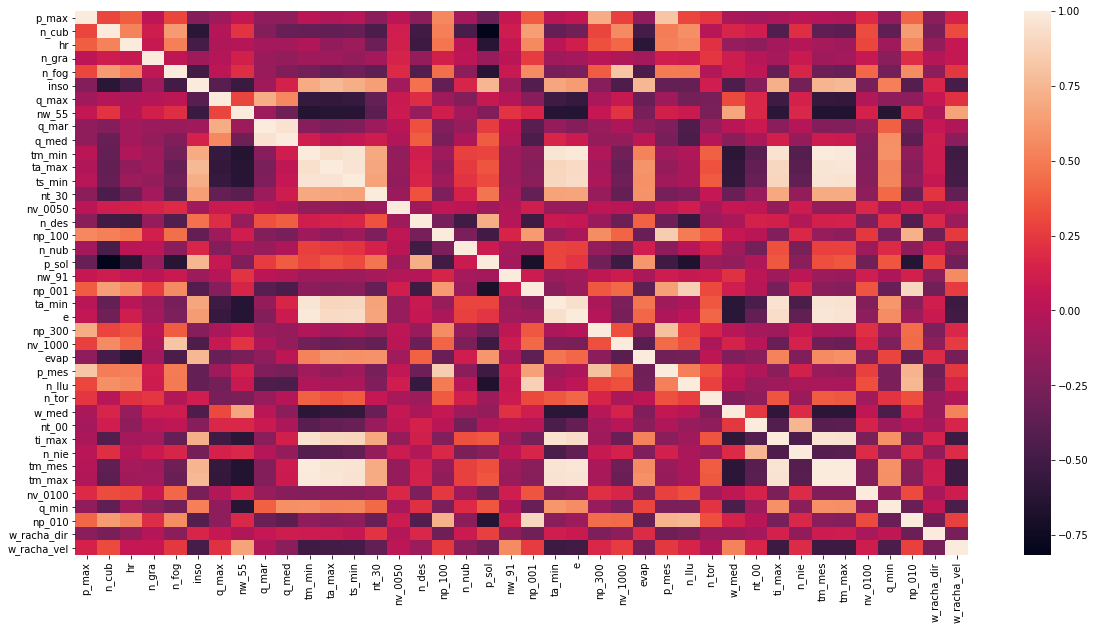

In [662]:
#Correlación entre variables
sns.heatmap(df2.corr())
plt.show()

- **Análisis:**

La **variable dependiente** es **p_mes** (precipitaciones por mes (mm)).

Se han **eliminado las variables independientes que tienen una elevada correlación con ella**, valores superiores a 0.8, por ejemplo: **p_max** (media precipitaciones máximas) $\sigma$=0.82 o **np_100** (número de días con precipitaciones superiores a 10mm por mes) $\sigma$=0.86.

No se han utilizado **tampoco variables independientes que tienen una elevada correlación entre ellas**, por ejemplo: **tm_max** (media temperatura máximas por mes) tiene una correlación de $\sigma$=0.96 con t_mes (temperartura media por mes).

Por último, no se han considerado las variables independientes que no permiten explicar la precipitación, aquellas con p_valor>0.

In [670]:
X_=df2.drop(['fecha','p_mes','p_max','np_300','np_100','n_cub','n_gra','n_fog','ta_max','nv_0050',\
            'w_racha_vel','inso','ts_min','q_min','nw_55','w_med','e','np_001','nw_91','ti_max',\
            'nt_00','n_nub','nt_30','n_nie','n_des','p_sol','ta_min','tm_min','tm_max','n_llu',\
            'w_racha_dir','nv_1000','evap','q_max','hr','n_tor','nv_0100'],'columns')
y_=df2.p_mes

In [671]:
X_t = RobustScaler().fit_transform(X_)
X_=pd.DataFrame(X_t,columns=X_.columns, index=X_.index)

In [672]:
#train y test sets (20% test set)
X_train,X_test,y_train,y_test=train_test_split(X_,y_,test_size=0.2,random_state=42)

In [673]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  p_mes   R-squared (uncentered):                   0.737
Model:                            OLS   Adj. R-squared (uncentered):              0.732
Method:                 Least Squares   F-statistic:                              138.1
Date:                Wed, 14 Jul 2021   Prob (F-statistic):                    5.26e-56
Time:                        17:11:17   Log-Likelihood:                         -989.88
No. Observations:                 201   AIC:                                      1988.
Df Residuals:                     197   BIC:                                      2001.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
q_mar        169.9262     10.417     16.312      0.000     149.383     190.470
q_med       -157.9215     10.115    -15.612      0.000    -177.870    -137.973
tm_mes        95.6122      6.596     14.496      0.000      82.604     108.620
np_010        48.1213      3.851     12.497      0.000      40.527      55.715
==============================================================================
Omnibus:                       75.793   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.564
Skew:                           1.545   Prob(JB):                     6.42e-55
Kurtosis:                       7.501   Cond. No.                         9.24
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [682]:
results.params.sort_values(ascending=False)

q_mar     169.926181
tm_mes     95.612191
np_010     48.121254
q_med    -157.921479
dtype: float64

In [683]:
#train metrics
r2_train=np.round(results.rsquared,2)
y_pred=results.predict(X_train)
mse_train=np.round(mean_squared_error(y_train,y_pred),1)
print('Regresión múltiple (Train set):')
print('r2: %s, mse: %s' %(r2_train,mse_train))

Regresión múltiple (Train set):
r2: 0.74, mse: 1109.5


In [684]:
#test metrics
y_pred1=results.predict(X_test)
r2_test=np.round(r2_score(y_test,y_pred1),2)
mse_test=np.round(mean_squared_error(y_test,y_pred1),1)
print('Regresión múltiple (Test set):')
print('r2: %s, mse: %s' %(r2_test,mse_test))

Regresión múltiple (Test set):
r2: 0.55, mse: 1297.8


- **Análisis:**

En la regresión se confirma que tanto la presión como la temperatura son dos de los parámetros más importantes que explican el fenómeno de la lluvia: **q_mar** (**presión a nivel del mar**(hPA)) y **tm_mes** (**temperatura media mensual** (grados Celsius)).

En cambio, en este caso, la variable **hr** (**humedad relativa mensual** (%)) no aportaba información suficiente.

El **modelo** tiene una buena **bondad de ajuste** para el conjunto **train (r<sup>2</sup>=0.74**) pero para el conjunto **test** es muy inferior **(r<sup>2</sup>=0.55)** indicando que el modelo está **sorbremuestreado.**

- **Random Forest**

In [685]:
from sklearn.ensemble import RandomForestRegressor

In [700]:
rf=RandomForestRegressor(n_estimators=40,min_samples_leaf=15,random_state=142 )
rf.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=15, n_estimators=40, random_state=142)

In [701]:
y_pred=rf.predict(X_train)
r2_train=np.round(r2_score(y_train,y_pred),2)
mse_train=np.round(mean_squared_error(y_train,y_pred),2)
print('Random Forest (Train set):')
print('r2: %s, mse: %s' %(r2_train,mse_train))

Random Forest (Train set):
r2: 0.5, mse: 955.73


In [702]:
y_pred3=rf.predict(X_test)
r2_test=np.round(r2_score(y_test,y_pred3),2)
mse_test=np.round(mean_squared_error(y_test,y_pred3),2)
print('Random Forest (Test set):')
print('r2: %s, mse: %s' %(r2_test,mse_test))

Random Forest (Test set):
r2: 0.6, mse: 1157.83


Se usa un **segundo modelo**, en este caso **RandomForest** para reducir el overfitting. Ahora se consigue que el modelo **no esté sobreentrenado**, a cambio de perder algo en la bondad de ajuste en el train set pero mejora la del **test** set, se obtiene un **60%**.

- **Predicción año 2020:**

In [708]:
y_pred_2020=rf.predict(X_.iloc[-12:])
y_real_2020=y_[-12:]

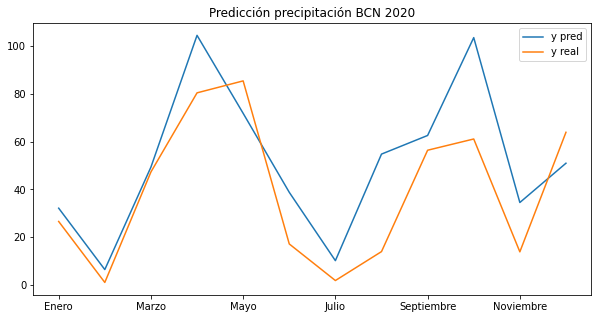

In [735]:
plt.figure(figsize=(10,5))
plt.plot(y_pred_2020, label='y pred')
plt.plot(y_real_2020.values, label='y real')
plt.legend()
labels=['Enero','Marzo','Mayo','Julio','Septiembre','Noviembre']
plt.xticks([*range(0,12,2)],labels)
plt.title('Predicción precipitación BCN 2020')
plt.show()

- **Análisis:**

Se observa que el modelo **es capaz de seguir la tendencia y la estacionalidad de la serie temporal** pero **no predice correctamente** los casos **cuando llueve más**. En los meses de Abril y Octubre de 2020 llovió menos de lo previsto y el modelo muestra mayores precipitaciones.

## 5. Conclusiones:

**Barcelona** es una ciudad donde más del **75% días del año no llueve** ni una sola gota pero **no se observa un aumento de este tipo de días en las últimas décadas**.Tampoco en sentido contrario, los días muy lluviosos se producen con la misma frecuencia antes y después del año 2000.

A nivel **mensual**, sí se observa un pequeño **cambio** en el comportamiento de las precipitaciones entre los dos periodos. En los dos casos existe estacionalidad, llueve más en los meses de primavera y otoño pero en los **últimos 20 años** los **periodos de pocas lluvias y mayores precipitaciones son más extremos**. Los meses de Junio, Julio y Agosto son mucho más secos que antes mientras que Octubre y Noviembre, los meses habituales de lluvia, llueve más.

Analizando todo el **histórico de precipitaciones** se observa un **ciclo** que se repite: **un año lluvioso con varios años secos**. En las dos últimas décadas la cantidad de lluvia recogida en los años lluviosos ha sido menor y los años secos han aumentado por lo que la tendencia de la serie temporal se ha reducido. Hay que destacar que 2018 fue un año que llovió mucho e hizo que la tendencia volviera a crecer.

También se ha aplicado un algoritmo no supervisado, **KMeans**, a las precipitaciones a nivel mensual dividiendo los meses en **dos clusters según la cantidad de lluvia** caída en la ciudad. Se ha comparado, con esta nueva división los dos periodos en estudio, y se confirma que en las últimas dos décadas los periodos de pocas lluvias y mayores precipitaciones son más extremos.

Por último, se ha utilizado dos algoritmos supervisados, **regresión lineal múltiple y Random Forest**, para poder predecir las **precipitaciones a partir de** magnitudes como la **temperatura, presión y humedad relativa**. El mejor modelo ha sido **Random Forest** con una bondad de ajuste del **60%.**